In [ ]:
import numpy as np
import pandas as pd
import requests
import os
import json
import time
from glob import glob
from datetime import datetime, timedelta
from urllib.parse import quote
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [ ]:
# Variables
api_key = 'd79586f663c1439588d50100251301'
city = 'Goa'
start_date = datetime.strptime('2008-08-01', '%Y-%m-%d')
end_date = datetime.strptime('2009-08-01', '%Y-%m-%d')
frequency = '1'  # Hourly

In [ ]:
# Function to generate monthly date ranges
def generate_month_ranges(start, end):
    current = start
    while current <= end:
        month_end = (current.replace(day=28) + timedelta(days=4)).replace(day=1) - timedelta(days=1)
        if month_end > end:
            month_end = end
        yield current, month_end
        current = month_end + timedelta(days=1)

In [ ]:
# Ensure the directory exists
os.makedirs('./data', exist_ok=True)

In [ ]:

# Loop through each month and download data with progress bar
for start, end in tqdm(generate_month_ranges(start_date, end_date), desc="Downloading data"):
    file_path = f'./data/weather_{city}_{start.strftime("%Y_%m")}.json'

    # Check if the file already exists
    if os.path.exists(file_path):
        print(f"File for {start.strftime('%Y-%m')} already exists. Skipping download.")
        continue

    encoded_city = quote(city)
    url = (f'http://api.worldweatheronline.com/premium/v1/past-weather.ashx'
           f'?key={api_key}&q={encoded_city}&format=json&date={start.strftime("%Y-%m-%d")}'
           f'&enddate={end.strftime("%Y-%m-%d")}&tp={frequency}')

    print(f"Starting download for {start.strftime('%Y-%m')} to {end.strftime('%Y-%m')}...")

    try:
        response = requests.get(url, timeout=10)
        response.raise_for_status()  # Raise an error for HTTP errors
        monthly_data = response.json()

        # Check if 'data' and 'weather' keys are present
        if 'data' in monthly_data and 'weather' in monthly_data['data']:
            with open(file_path, 'w') as f:
                json.dump(monthly_data, f)
            print(f"Saved data for {start.strftime('%Y-%m')}")
        else:
            print(f"Unexpected structure for {start.strftime('%Y-%m')}: Missing 'weather' key")

    except requests.exceptions.RequestException as e:
        print(f"Error fetching data for {start.strftime('%Y-%m')}: {e}")

    time.sleep(1)  # Sleep to avoid hitting rate limits

print("Data download complete.")

File for 2008-07 already exists. Skipping download.
File for 2008-08 already exists. Skipping download.
File for 2008-09 already exists. Skipping download.
File for 2008-10 already exists. Skipping download.
File for 2008-11 already exists. Skipping download.
File for 2008-12 already exists. Skipping download.
File for 2009-01 already exists. Skipping download.
File for 2009-02 already exists. Skipping download.
File for 2009-03 already exists. Skipping download.
File for 2009-04 already exists. Skipping download.
File for 2009-05 already exists. Skipping download.
File for 2009-06 already exists. Skipping download.
File for 2009-07 already exists. Skipping download.
File for 2009-08 already exists. Skipping download.
File for 2009-09 already exists. Skipping download.
File for 2009-10 already exists. Skipping download.
File for 2009-11 already exists. Skipping download.
File for 2009-12 already exists. Skipping download.
File for 2010-01 already exists. Skipping download.
File for 201

In [ ]:
# Combine all weather data into one JSON
combined_data = []

# Loop through each file
for filename in glob('./data/weather_*.json'):
    with open(filename, 'r') as file:
        data = json.load(file)
        try:
            if 'data' in data and 'weather' in data['data']:
                combined_data.extend(data['data']['weather'])
            else:
                print(f"KeyError for {filename}: Missing 'weather' key")
        except KeyError as e:
            print(f"KeyError for {filename}: {e}")

# Save the combined data
output_filename = './data/combined_weather_data.json'
with open(output_filename, 'w') as outfile:
    json.dump({'data': {'weather': combined_data}}, outfile, indent=4)

print(f'All weather data has been combined and saved to {output_filename}')

KeyError for ../data\weather_Goa_2007_01.json: Missing 'weather' key
KeyError for ../data\weather_Goa_2007_02.json: Missing 'weather' key
KeyError for ../data\weather_Goa_2007_03.json: Missing 'weather' key
KeyError for ../data\weather_Goa_2007_04.json: Missing 'weather' key
KeyError for ../data\weather_Goa_2007_05.json: Missing 'weather' key
KeyError for ../data\weather_Goa_2007_06.json: Missing 'weather' key
KeyError for ../data\weather_Goa_2007_07.json: Missing 'weather' key
KeyError for ../data\weather_Goa_2007_08.json: Missing 'weather' key
KeyError for ../data\weather_Goa_2007_09.json: Missing 'weather' key
KeyError for ../data\weather_Goa_2007_10.json: Missing 'weather' key
KeyError for ../data\weather_Goa_2007_11.json: Missing 'weather' key
KeyError for ../data\weather_Goa_2007_12.json: Missing 'weather' key
KeyError for ../data\weather_Goa_2008_01.json: Missing 'weather' key
KeyError for ../data\weather_Goa_2008_02.json: Missing 'weather' key
KeyError for ../data\weather_Goa_2

In [ ]:
# Load the combined JSON data
with open('./data/combined_weather_data.json', 'r') as file:
    combined_data = json.load(file)

# Extract the hourly data
hourly_data_list = []

for weather_day in combined_data['data']['weather']:
    date = weather_day['date']
    for hourly_data in weather_day['hourly']:
        # Flatten the hourly data and add the date to each entry
        hourly_data_flattened = {
            'date_time': f"{date} {int(hourly_data['time'])//100:02d}:00",  # Combines date and time
            'tempC': hourly_data['tempC'],
            'humidity': hourly_data['humidity'],
            'pressure': hourly_data['pressure'],
            'precipMM': hourly_data['precipMM'],
            'uvIndex': hourly_data['uvIndex'],
            'windspeedKmph': hourly_data['windspeedKmph'],
            'winddirDegree': hourly_data['winddirDegree'],
            'weatherDesc': hourly_data['weatherDesc'][0]['value'],  # Assumes first description is primary
        }
        hourly_data_list.append(hourly_data_flattened)

# Create a pandas DataFrame from the list of dictionaries
hourly_df = pd.DataFrame(hourly_data_list)

# Convert columns to numeric, if possible
numeric_cols = ['tempC', 'humidity', 'pressure', 'precipMM', 'uvIndex', 'windspeedKmph', 'winddirDegree']
hourly_df[numeric_cols] = hourly_df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Convert the 'date_time' column to datetime
hourly_df['date_time'] = pd.to_datetime(hourly_df['date_time'], format='%Y-%m-%d %H:%M')

# Set the 'date_time' as the index of the DataFrame
hourly_df.set_index('date_time', inplace=True)

# Save the DataFrame to a CSV file
csv_file_path = './data/weather_data_goa_hourly.csv'
hourly_df.to_csv(csv_file_path, index=True)

print(f'Hourly weather data saved to CSV file at: {csv_file_path}')

# Now hourly_df is a pandas DataFrame containing all the hourly data

Hourly weather data saved to CSV file at: ../data/weather_data_goa_hourly.csv


- `pd.to_numeric()` is used to convert temperature and other specified columns to a numeric type. The `errors='coerce'` argument ensures that if any non-numeric values are encountered, they will be set to NaN (which stands for 'Not a Number') instead of raising an error.

In [ ]:
# Sort the DataFrame by date_time
hourly_df.sort_values(by='date_time', inplace=True)

In [ ]:
hourly_df

,tempC,humidity,pressure,precipMM,uvIndex,windspeedKmph,winddirDegree,weatherDesc
date_time,,,,,,,,
2008-07-01 00:00:00,21,96,1018,0.0,1,2,120,Clear
2008-07-01 01:00:00,20,96,1018,1.1,1,2,88,Heavy rain at times
2008-07-01 02:00:00,20,97,1018,0.3,1,2,56,Patchy rain possible
2008-07-01 03:00:00,21,97,1018,0.0,1,3,24,Partly cloudy
2008-07-01 04:00:00,21,96,1018,1.0,1,4,20,Heavy rain at times
...,...,...,...,...,...,...,...,...
2024-09-01 19:00:00,25,60,1011,0.3,1,10,141,Patchy rain possible
2024-09-01 20:00:00,23,68,1012,0.0,1,11,224,Patchy rain possible
2024-09-01 21:00:00,22,76,1013,0.0,1,12,240,Clear


In [ ]:
hourly_df.isna().sum()

tempC            0
humidity         0
pressure         0
precipMM         0
uvIndex          0
windspeedKmph    0
winddirDegree    0
weatherDesc      0
dtype: int64

In [ ]:
hourly_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 141648 entries, 2008-07-01 00:00:00 to 2024-09-01 23:00:00
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   tempC          141648 non-null  int64  
 1   humidity       141648 non-null  int64  
 2   pressure       141648 non-null  int64  
 3   precipMM       141648 non-null  float64
 4   uvIndex        141648 non-null  int64  
 5   windspeedKmph  141648 non-null  int64  
 6   winddirDegree  141648 non-null  int64  
 7   weatherDesc    141648 non-null  object 
dtypes: float64(1), int64(6), object(1)
memory usage: 9.7+ MB


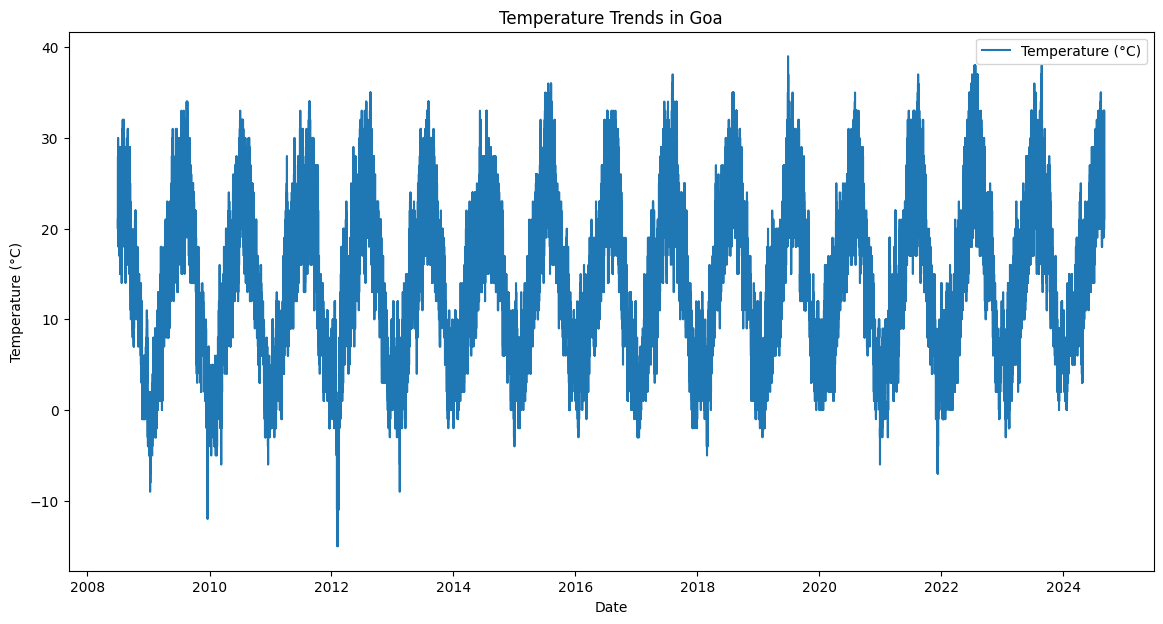

In [ ]:
# Temperature Trends Over Time
plt.figure(figsize=(14, 7))
plt.plot(hourly_df['tempC'], label='Temperature (°C)')
plt.title('Temperature Trends in Goa')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()

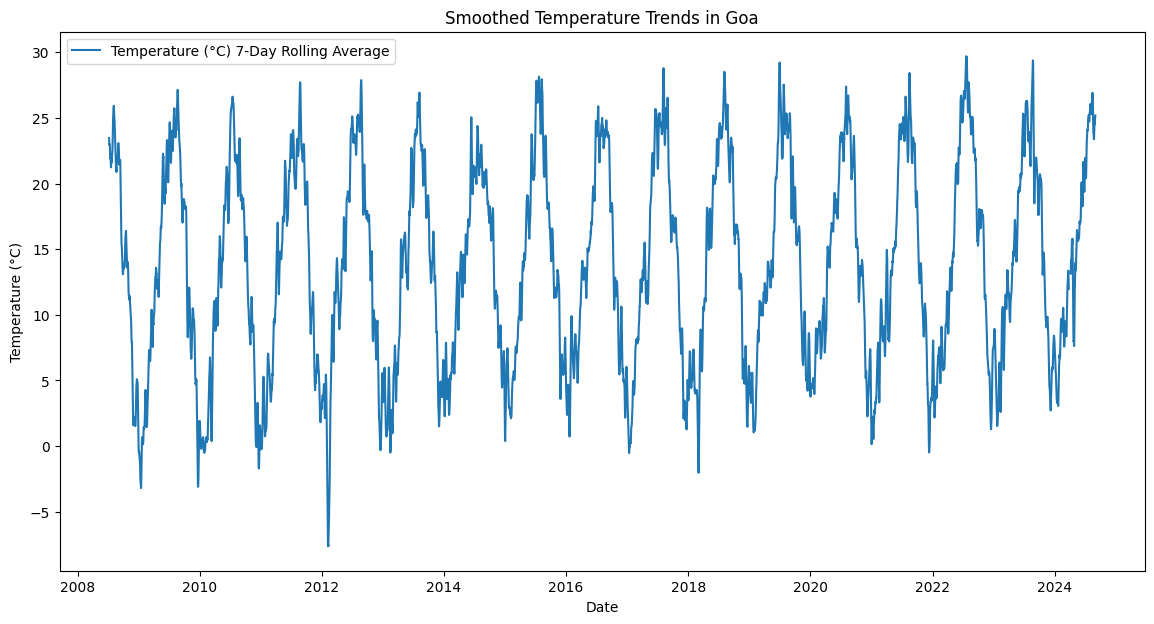

In [ ]:
# We should resample and calculate the mean for the numeric columns only
numeric_cols = ['tempC', 'humidity', 'pressure', 'precipMM', 'uvIndex', 'windspeedKmph', 'winddirDegree']

# Non-numeric columns will be excluded
df_daily = hourly_df[numeric_cols].resample('D').mean()

# Calculate a 7-day rolling average for temperature
df_daily['tempC_rolling'] = df_daily['tempC'].rolling(window=7).mean()

# Plot the rolling average temperature
plt.figure(figsize=(14, 7))
plt.plot(df_daily.index, df_daily['tempC_rolling'], label='Temperature (°C) 7-Day Rolling Average')
plt.title('Smoothed Temperature Trends in Goa')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()

In this code snippet:

- After converting the columns to numeric types, the data is resampled by day (`'D'`) to calculate the daily mean temperatures.
- A rolling average with a 7-day window is computed for the temperature, which smooths out the data for better trend visualization.
- The plot is then generated using the rolling average data, which should give a smoother curve and a more accurate representation of the temperature trends over time.

### Trend line on the daily mean temperature

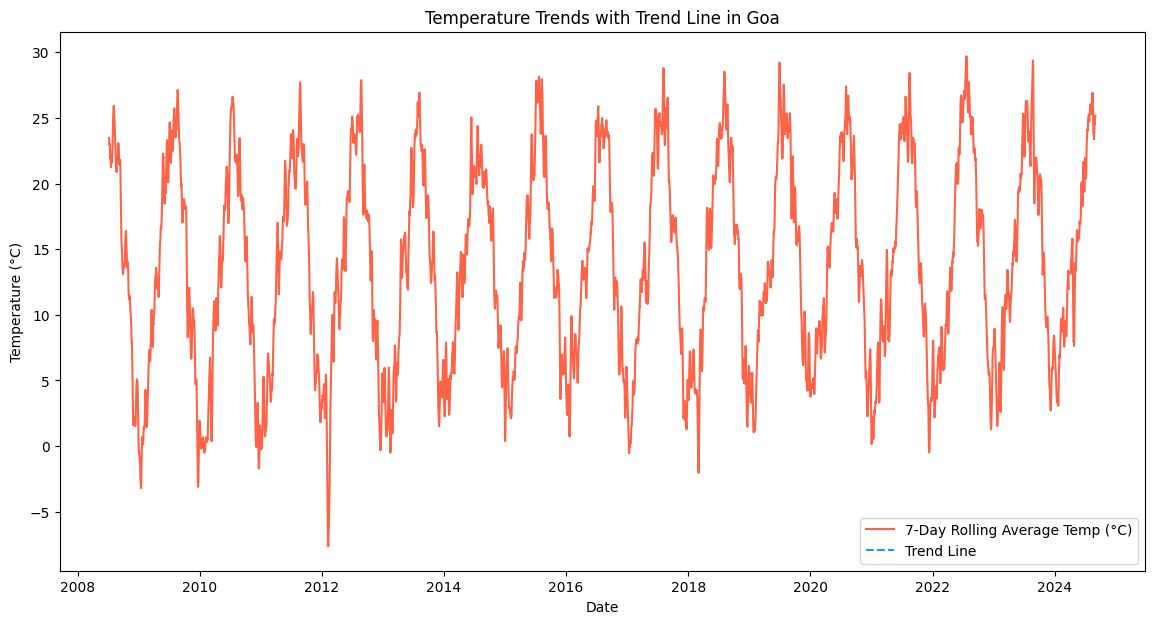

In [ ]:
# Fit a simple linear regression (trend line) on the daily mean temperature
# First, we need to create a series of ordinal date numbers for regression
df_daily['date_ordinal'] = df_daily.index.map(pd.Timestamp.toordinal)

# Then, use numpy's polyfit to fit a first degree polynomial (linear)
# The polyfit function returns the coefficients for the equation of the line
coefficients = np.polyfit(df_daily['date_ordinal'], df_daily['tempC'], 1)

# Use the coefficients to create the equation of the line
polynomial = np.poly1d(coefficients)

# Now we can create y-values for our trend line based on the date ordinals
df_daily['trend_line'] = polynomial(df_daily['date_ordinal'])

#Plotting the temperature and trend line
plt.figure(figsize=(14, 7))
plt.plot(df_daily.index, df_daily['tempC_rolling'], label='7-Day Rolling Average Temp (°C)', color='tomato')
plt.plot(df_daily.index, df_daily['trend_line'], label='Trend Line', color='dodgerblue', linestyle='--')
plt.title('Temperature Trends with Trend Line in Goa')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()

In this code:

- `np.polyfit` is used to fit a linear trend line to the daily mean temperatures.
- `np.poly1d` creates a polynomial from the coefficients returned by `polyfit`.
- We add a new column to `df_daily` called 'trend_line', which stores the values of the trend line.
- The trend line is plotted along with the 7-day rolling average of temperature.


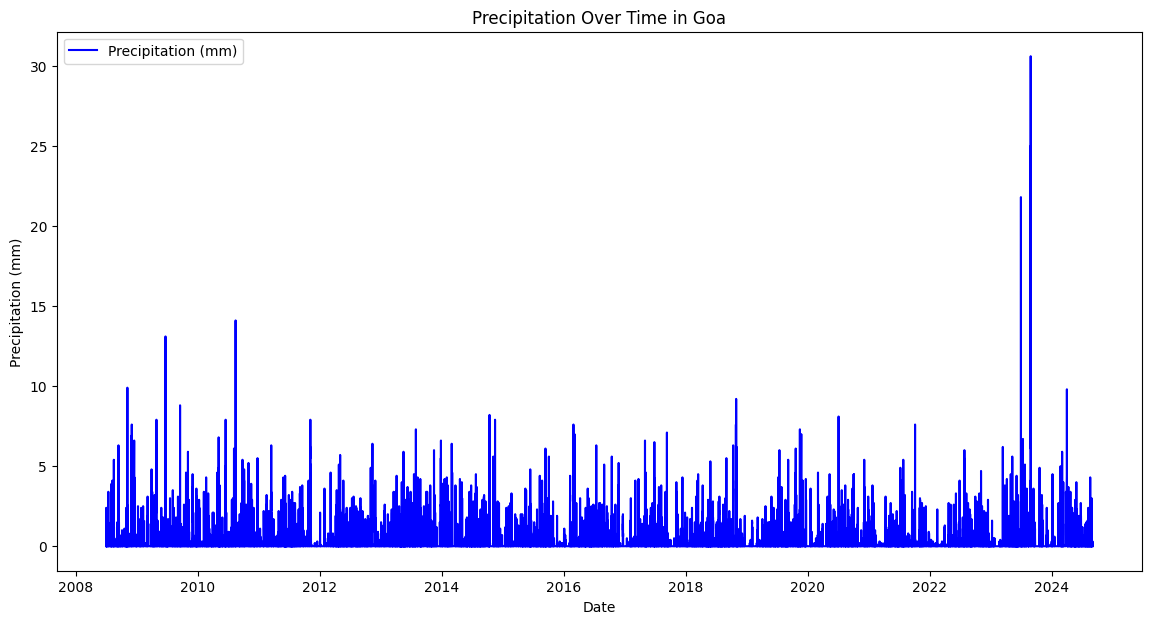

In [ ]:
# Precipitation Over Time
plt.figure(figsize=(14, 7))
plt.plot(hourly_df['precipMM'], label='Precipitation (mm)', color='blue')
plt.title('Precipitation Over Time in Goa')
plt.xlabel('Date')
plt.ylabel('Precipitation (mm)')
plt.legend()
plt.show()

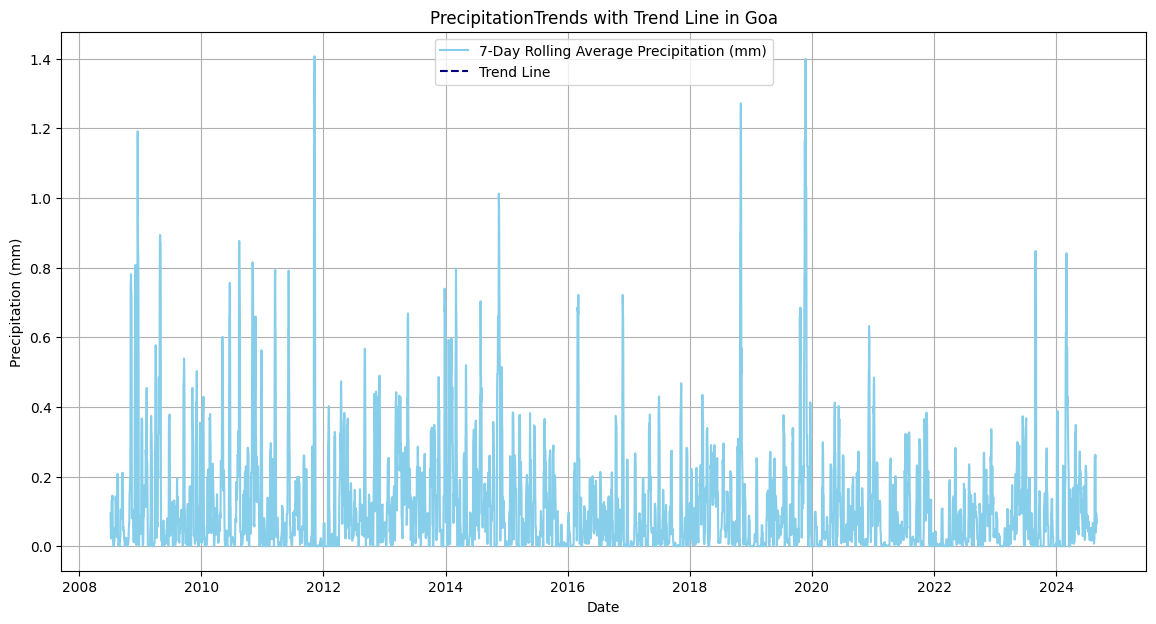

In [ ]:
# Calculate a 7-day rolling average for precipitation
df_daily['precipMM_rolling'] = df_daily['precipMM'].rolling(window=7).mean()

# Fit a simple linear regression (trend line) on the daily mean precipitation
df_daily['date_ordinal'] = df_daily.index.map(pd.Timestamp.toordinal)
coefficients = np.polyfit(df_daily['date_ordinal'], df_daily['precipMM'], 1)
polynomial = np.poly1d(coefficients)
df_daily['trend_line'] = polynomial(df_daily['date_ordinal'])

# Plotting the rolling average of precipitation with a trend line
plt.figure(figsize=(14, 7))
plt.plot(df_daily.index, df_daily['precipMM_rolling'], label='7-Day Rolling Average Precipitation (mm)', color='skyblue')
plt.plot(df_daily.index, df_daily['trend_line'], label='Trend Line', color='navy', linestyle='--')
plt.title('PrecipitationTrends with Trend Line in Goa')
plt.xlabel('Date')
plt.ylabel('Precipitation (mm)')
plt.legend()
plt.grid(True)
plt.show()

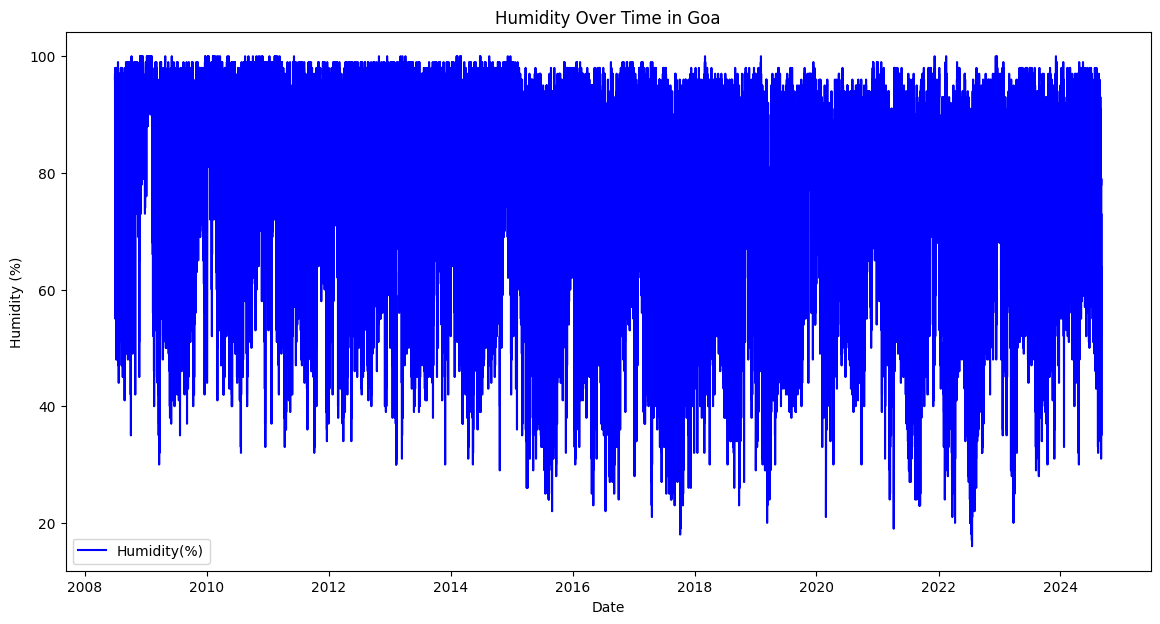

In [ ]:
# Precipitation Over Time
plt.figure(figsize=(14, 7))
plt.plot(hourly_df['humidity'], label='Humidity(%)', color='blue')
plt.title('Humidity Over Time in Goa')
plt.xlabel('Date')
plt.ylabel('Humidity (%)')
plt.legend()
plt.show()